In [2]:
%load_ext cython
%matplotlib inline
import pylab as pl
import numpy as np
import ctypes

## Cython技巧集

### 创建ufunc函数

> **LINK**

> http://docs.scipy.org/doc/numpy-dev/user/c-info.ufunc-tutorial.html

使用NumPy的C-API编写ufunc函数的教程

In [3]:
%%cython
from libc.math cimport exp
from numpy cimport (PyUFuncGenericFunction, npy_intp, import_ufunc, 
                    NPY_DOUBLE, PyUFunc_None, PyUFunc_FromFuncAndData) #❶

import_ufunc() #❷
  
cdef void double_logistic(char **args, npy_intp *dimensions,
                            npy_intp* steps, void* data):
    cdef: #用缩进可以定义多行cdef变量
        npy_intp i
        npy_intp n = dimensions[0]
        char *in_ptr = args[0]
        char *out_ptr = args[1]
        npy_intp in_step = steps[0]
        npy_intp out_step = steps[1]

        double x, y
        
    for i in range(n):
        x = (<double *>in_ptr)[0]
        y = 1.0 / (1.0 + exp(-x))
        (<double *>out_ptr)[0] = y
        
        in_ptr += in_step
        out_ptr += out_step

cdef:
    PyUFuncGenericFunction *functions = [&double_logistic] #❸
    char *signatures = [NPY_DOUBLE, NPY_DOUBLE] #❹
    void **data = [NULL] #❺

logistic1 = PyUFunc_FromFuncAndData(functions, data, signatures, #❻
                    1, #ntypes
                    1, #nin 
                    1, #nout
                    PyUFunc_None, #identity
                    "logistic", #name
                    "a sigmoid function: y = 1 / (1 + exp(-x))", #doc string
                    0) # unused

In [4]:
logistic1([-1, 0, 1])

array([ 0.26894142,  0.5       ,  0.73105858])

In [5]:
%%cython
from libc.math cimport exp
from numpy cimport (PyUFuncGenericFunction, import_ufunc, PyUFunc_d_d,
                    NPY_DOUBLE, PyUFunc_None, PyUFunc_FromFuncAndData)

import_ufunc()

cdef double scalar_logistic(double x): #❶
    return 1.0 / (1.0 + exp(-x))

cdef:
    PyUFuncGenericFunction *functions = [PyUFunc_d_d] #❷
    char *signatures = [NPY_DOUBLE, NPY_DOUBLE]
    void **data = [&scalar_logistic] #❸


logistic2 = PyUFunc_FromFuncAndData(functions, data, signatures, 
                    1, 1, 1, PyUFunc_None, 
                    "logistic", 
                    "a sigmoid function: y = 1 / (1 + exp(-x))", 
                    0)

In [6]:
x = np.linspace(-6, 6, 10000)
%timeit logistic1(x)
%timeit logistic2(x)

10000 loops, best of 3: 201 µs per loop
1000 loops, best of 3: 208 µs per loop


In [5]:
%%cython
include "numpy_ufuncs.pxi"
from libc.math cimport exp

cdef double scalar_logistic(double x):
    return 1.0 / (1.0 + exp(-x))

cdef double scalar_peaks(double x, double y):
    return x * exp(-x*x - y*y)

logistic3 = register_ufunc_d(scalar_logistic, 
                            "logistic", "logistic function", PyUFunc_None)

peaks = register_ufunc_dd(scalar_peaks,
                          "peaks", "peaks function", PyUFunc_None)

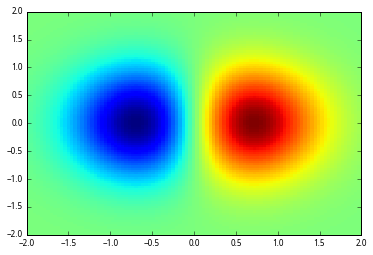

In [6]:
#%nofig
Y, X = np.ogrid[-2:2:100j, -2:2:100j]
pl.pcolormesh(X, Y, peaks(X, Y));

### 快速调用DLL中的函数

In [9]:
%%file peaks.c
#include <math.h>
double peaks(double x, double y)
{
    return x * exp(-x*x - y*y);
}

unsigned int get_addr()
{
    return (unsigned int)(void *)peaks;
}

Overwriting peaks.c


In [10]:
!gcc -Ofast -shared -o peaks.dll peaks.c

In [9]:
import ctypes
lib = ctypes.CDLL("peaks.dll")
lib.peaks.argtypes = [ctypes.c_double, ctypes.c_double]
lib.peaks.restype = ctypes.c_double
lib.peaks(1.0, 2.0)

0.006737946999085465

In [10]:
addr = ctypes.cast(lib.peaks, ctypes.c_void_p).value
addr == lib.get_addr()

True

In [11]:
%%cython
import cython
import numpy as np
from ctypes import cast, c_void_p

ctypedef double(*Function)(double x, double y)      #❶

@cython.wraparound(False)
@cython.boundscheck(False)
def vectorize_2d(func, double[:, ::1] x, double[:, ::1] y):
    cdef double[:, ::1] res = np.zeros_like(x.base)
    cdef size_t addr = cast(func, c_void_p).value   #❷
    cdef Function func_ptr = <Function><void *>addr #❸
    cdef int i, j
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            res[i, j] = func_ptr(x[i, j], y[i, j])
            
    return res.base

In [18]:
Y, X = np.mgrid[-2:2:200j, -2:2:200j]
vectorize_peaks = np.vectorize(lib.peaks, otypes=['f8'])
np.allclose(vectorize_peaks(X, Y), vectorize_2d(lib.peaks, X, Y))

True

In [15]:
%%cython
include "numpy_ufuncs.pxi"
from ctypes import cast, c_void_p

cdef class UFunc_dd:
    cdef public object ufunc #❶
    
    def __cinit__(self, func): #❷
        cdef size_t addr = cast(func, c_void_p).value
        self.ufunc = register_ufunc_dd(<double (*)(double, double)>addr, 
                                       "ufunc", "variable ufunc", PyUFunc_None)        
    def set_func(self, func):
        cdef ufunc f = <ufunc> self.ufunc #❸
        cdef size_t addr = cast(func, c_void_p).value 
        f.data[0] = <void *>addr #❹
        f.data[1] = <void *>addr

In [19]:
ufunc_dd = UFunc_dd(lib.peaks)
Y, X = np.ogrid[-2:2:200j, -2:2:200j]
assert np.allclose(vectorize_peaks(X, Y), ufunc_dd.ufunc(X, Y))

ufunc_dd.set_func(ctypes.cdll.msvcrt.atan2)
assert np.allclose(np.arctan2(X, Y), ufunc_dd.ufunc(X, Y))

### 调用BLAS函数

#### 包装`saxpy()`函数

In [22]:
from scipy.linalg import blas
import numpy as np
x = np.array([1, 2, 3], np.float32)
y = np.array([1, 3, 5], np.float32)
blas.saxpy(x, y, a=0.5)

array([ 1.5,  4. ,  6.5], dtype=float32)

In [23]:
blas.saxpy

<fortran object>

In [24]:
import ctypes
saxpy_addr = ctypes.pythonapi.PyCObject_AsVoidPtr(ctypes.py_object(blas.saxpy._cpointer))
saxpy_addr

196931082

> **LINK**

> http://www.netlib.org/lapack/explore-html/d8/daf/saxpy_8f.html
>
> BLAS库中saxpy()的函数原型

In [39]:
%%cython
import cython
from cpython cimport PyCObject_AsVoidPtr
from scipy.linalg import blas

ctypedef void (*saxpy_ptr) (const int *N, const float *alpha, 
    const float *X, const int *incX, float *Y, const int *incY) nogil
cdef saxpy_ptr _saxpy=<saxpy_ptr>PyCObject_AsVoidPtr(blas.saxpy._cpointer)

def blas_saxpy(float[:] y, float a, float[:] x):
    cdef int n = y.shape[0]
    cdef int inc_x = x.strides[0] / sizeof(float)
    cdef int inc_y = y.strides[0] / sizeof(float)
    _saxpy(&n, &a, &x[0], &inc_x, &y[0], &inc_y)
    
@cython.wraparound(False)
@cython.boundscheck(False)
def cython_saxpy(float[:] y, float a, float[:] x):
    cdef int i
    for i in range(y.shape[0]):
        y[i] += a * x[i]

In [40]:
a = np.arange(100000, dtype=np.float32)
b = np.zeros_like(a)
%timeit blas_saxpy(b, 0.2, a)
%timeit cython_saxpy(b, 0.2, a)

10000 loops, best of 3: 28.6 µs per loop
10000 loops, best of 3: 98.3 µs per loop


#### `dgemm()`高速矩阵乘积

> **LINK**

> http://www.netlib.org/lapack/explore-html/d7/d2b/dgemm_8f.html
>
> DGEMM的说明文档

In [20]:
%%cython -c-Ofast -c-fopenmp --link-args=-fopenmp

from cython.parallel import prange #❶
import cython
import numpy as np
from cpython cimport PyCObject_AsVoidPtr
from scipy.linalg import blas

ctypedef void (*dgemm_ptr) (char *ta, char *tb, 
                            int *m, int *n, int *k,
                            double *alpha,
                            double *a, int *lda,
                            double *b, int *ldb,
                            double *beta,
                            double *c, int *ldc) nogil

cdef dgemm_ptr _dgemm=<dgemm_ptr>PyCObject_AsVoidPtr(blas.dgemm._cpointer)

@cython.wraparound(False)
@cython.boundscheck(False)
def dgemm(double[:, :, :] A, double[:, :, :] B, int[:, ::1] index):
    cdef int m, n, k, i, length, idx_a, idx_b
    cdef double[:, :, :] C
    cdef char ta, tb
    cdef double alpha = 1.0
    cdef double beta = 0.0
        
    length = index.shape[0]
    m, k, n  = A.shape[1], A.shape[2], B.shape[2]        
    
    C = np.zeros((length, n, m))
    
    ta = "T"
    tb = ta
    
    for i in prange(length, nogil=True): #❷
        idx_a = index[i, 0]
        idx_b = index[i, 1]
        _dgemm(&ta, &tb, &m, &n, &k, &alpha, 
               &A[idx_a, 0, 0], &k, 
               &B[idx_b, 0, 0], &n, 
               &beta,
               &C[i, 0, 0], &m)
    
    return C.base

In [21]:
def matrix_multiply(a, b):
    if a.ndim <= 2 and b.ndim <= 2:
        return np.dot(a, b)
    
    a = np.ascontiguousarray(a).astype(np.float, copy=False)
    b = np.ascontiguousarray(b).astype(np.float, copy=False)
    if a.ndim == 2:
        a = a[None, :, :]
    if b.ndim == 2:
        b = b[None, :, :]
        
    shape_a = a.shape[:-2]
    shape_b = b.shape[:-2]
    len_a = np.prod(shape_a)
    len_b = np.prod(shape_b)
    
    idx_a = np.arange(len_a, dtype=np.int32).reshape(shape_a)
    idx_b = np.arange(len_b, dtype=np.int32).reshape(shape_b)
    idx_a, idx_b = np.broadcast_arrays(idx_a, idx_b)
    
    index = np.column_stack((idx_a.ravel(), idx_b.ravel()))
    bshape = idx_a.shape
    
    if a.ndim > 3:
        a = a.reshape(-1, a.shape[-2], a.shape[-1])
    if b.ndim > 3:
        b = b.reshape(-1, b.shape[-2], b.shape[-1])
    
    if a.shape[-1] != b.shape[-2]:
        raise ValueError("can't do matrix multiply because k isn't the same")

    c = dgemm(a, b, index)
    c = np.swapaxes(c, -2, -1)
    c.shape = bshape + c.shape[-2:]
    return c

In [22]:
import numpy.core.umath_tests as umath
a = np.random.rand(12,  1, 10, 100, 30)
b = np.random.rand( 1, 15,  1,  30, 50)
np.allclose(matrix_multiply(a, b), umath.matrix_multiply(a, b))

True

In [23]:
%timeit matrix_multiply(a, b)
%timeit umath.matrix_multiply(a, b)

10 loops, best of 3: 47.8 ms per loop
1 loops, best of 3: 313 ms per loop
